In [9]:
import numpy as np

# Özellikleri ve etiketleri yükleme
resnet_features = np.load("resnet_features_1.npy")
efficientnet_features = np.load("efficientnet_features_1.npy")
labels = np.load("labels_1.npy")

# Özelliklerin birleştirilmesi
combined_features = np.concatenate([resnet_features, efficientnet_features], axis=1)

print("Özelliklerin boyutu:", combined_features.shape)
print("Etiketlerin boyutu:", labels.shape)


Özelliklerin boyutu: (15000, 4608)
Etiketlerin boyutu: (15000,)


In [10]:
from sklearn.model_selection import train_test_split     

X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=48)

* Özellik seçimi sonucu %99 test skoru elde edildi 

In [ ]:
'''
import lightgbm as lgb

# LightGBM kullanarak özellik önemi belirleme
lgb_model = lgb.LGBMClassifier(random_state=48)
lgb_model.fit(X_train, y_train)

# Özellik önemini hesaplama
feature_importances = lgb_model.feature_importances_

# En önemli özellikleri sırayla sıralama
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = sorted_indices[:300]  # İlk 300 

# LightGBM ile seçilen özellikleri filtreleme
X_train_lgb = X_train[:, top_features]
X_test_lgb = X_test[:, top_features]
print("LightGBM ile seçilen özelliklerin boyutu:", X_train_lgb.shape)
'''

In [5]:
'''
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Recursive Feature Elimination (RFE) ile özellik seçimi
rfe_model = RandomForestClassifier(random_state=48)
rfe = RFE(estimator=rfe_model, n_features_to_select=100, step=10)  # En iyi 100 özelliği seçiyoruz
X_train_rfe = rfe.fit_transform(X_train_lgb, y_train)
X_test_rfe = rfe.transform(X_test_lgb)
print("RFE ile seçilen özelliklerin boyutu:", X_train_rfe.shape)

# Seçilen özelliklerin kaydedilmesi
np.save("selected_features_train.npy", X_train_rfe)
np.save("selected_features_test.npy", X_test_rfe)
np.save("selected_labels_train.npy", y_train)
np.save("selected_labels_test.npy", y_test)

print("Özellik seçimi tamamlandı ve dosyalar kaydedildi.")
'''

RFE ile seçilen özelliklerin boyutu: (12000, 100)
Özellik seçimi tamamlandı ve dosyalar kaydedildi.


In [ ]:
# Seçilen özelliklerin yüklenmesi
'''
import numpy as np

X_train = np.load("selected_features_train.npy")
X_test = np.load("selected_features_test.npy")
y_train = np.load("selected_labels_train.npy")
y_test = np.load("selected_labels_test.npy")
'''

In [11]:
from tensorflow.keras.utils import to_categorical

# Hedef verilerin one-hot encoded hale getirilmesi
y_train_onehot = to_categorical(y_train, num_classes=3)  # 3 sınıf için
y_test_onehot = to_categorical(y_test, num_classes=3)

# Hedef veri boyutlarının kontrolü
print("y_train_onehot shape:", y_train_onehot.shape)  # Örn: (12000, 3)
print("y_test_onehot shape:", y_test_onehot.shape)    # Örn: (3000, 3)

y_train_onehot shape: (12000, 3)
y_test_onehot shape: (3000, 3)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# Modelin Tanımlanması
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train.shape[1]),  
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])


c:\Users\osman\Desktop\medical_image_processing\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Modelin Derlenmesi
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  # Çok sınıflı sınıflandırma için doğru kayıp fonksiyonu
              metrics=['accuracy'])

# EarlyStopping Tanımlama
early_stopping = EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik (val_loss: doğrulama kaybı)
    patience=8,          # İyileşme olmadan geçecek maksimum epoch sayısı
    restore_best_weights=True,  # En iyi ağırlıkları geri yükle
    verbose=1            # Eğitim sırasında durdurma mesajını yazdır
)

# Modelin Eğitilmesi (EarlyStopping ile)
with tf.device('/GPU:0'):  # GPU kullanımı
    history = model.fit(
        X_train, y_train_onehot,
        epochs=50,  # Maksimum epoch sayısı
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping],  # EarlyStopping ekleniyor
        verbose=1
    )

# Modelin Değerlendirilmesi
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Seti - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8634 - loss: 0.3057 - val_accuracy: 0.9721 - val_loss: 0.0780
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9604 - loss: 0.1086 - val_accuracy: 0.9792 - val_loss: 0.0528
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9805 - loss: 0.0545 - val_accuracy: 0.9717 - val_loss: 0.0796
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9855 - loss: 0.0470 - val_accuracy: 0.9904 - val_loss: 0.0196
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9865 - loss: 0.0355 - val_accuracy: 0.9971 - val_loss: 0.0133
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9940 - loss: 0.0189 - val_accuracy: 0.9967 - val_loss: 0.0114
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9934 - loss: 0.0151 - val_accuracy: 0.9879 - val_loss: 0.0364
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9935 - loss: 0.0178 - val_accuracy: 0.9967 - v

In [24]:
# Test verileri ile modeli değerlendirme
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Seti - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Test Seti - Loss: 0.0083, Accuracy: 0.9967


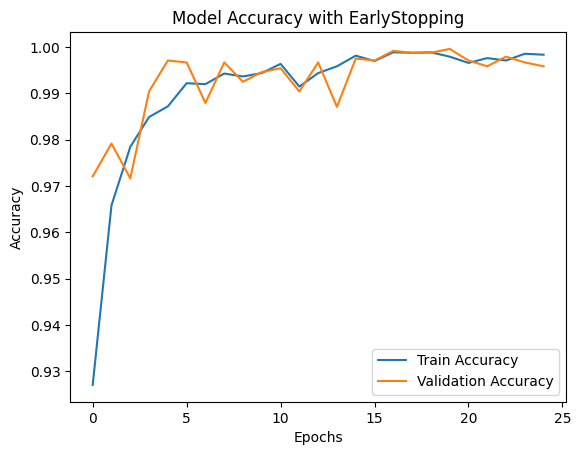

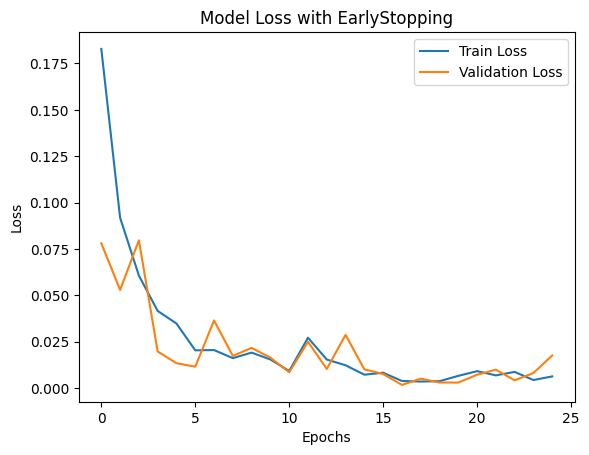

In [25]:

import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with EarlyStopping')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını görselleştirme
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss with EarlyStopping')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Test verileri üzerindeki tahminler
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıflar
y_true_classes = np.argmax(y_test_onehot, axis=1)  # Gerçek sınıflar

# Sınıflandırma raporu
report = classification_report(y_true_classes, y_pred_classes, target_names=["Lung adenocarcinoma", "Lung benign tissue", "Lung squamous cell carcinoma"],digits=6)
print("Sınıflandırma Raporu:")
print(report)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sınıflandırma Raporu:
                              precision    recall  f1-score   support

         Lung adenocarcinoma   0.992561  0.996798  0.994675       937
          Lung benign tissue   1.000000  1.000000  1.000000      1029
Lung squamous cell carcinoma   0.997087  0.993230  0.995155      1034

                    accuracy                       0.996667      3000
                   macro avg   0.996549  0.996676  0.996610      3000
                weighted avg   0.996673  0.996667  0.996667      3000



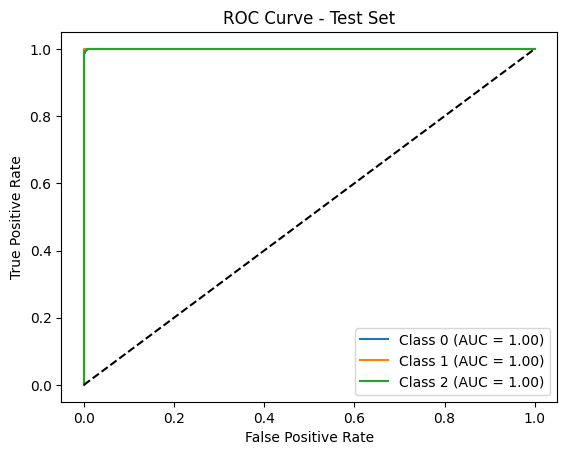

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ROC-AUC için etiketleri binarize etme (çok sınıflı ROC için)
y_true_binarized = label_binarize(y_true_classes, classes=[0, 1, 2])
n_classes = 3

# ROC ve AUC değerlerini hesaplama
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Rastgele tahmin eğrisi
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.show()


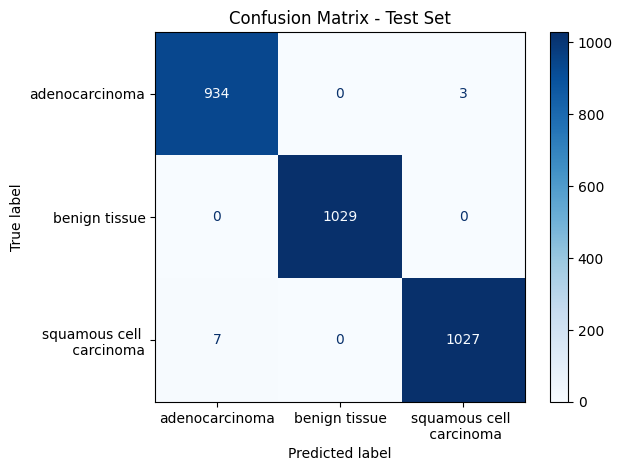

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["adenocarcinoma", "benign tissue", "squamous cell \n carcinoma"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


In [34]:
model.save("model_tensorflow.keras")

In [ ]:
'''
from tensorflow.keras.models import load_model

# Kaydedilen modeli yükleme
model = load_model("my_model.h5")

# Modeli değerlendirme
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
'''